# Traits prediction in Tsetse flies using restirctied number of wavenumbers using second derivative
Final jupyter notebook for sex, and age prediction of males and females flies using the infrared region from 1750-602 cm $^{-1}$. This notebooks creates the models and reproduces figure S3 and figure S4 of the manuscript. 


## Changelog
### 16/11/2023
Added extraction of top20 wavenumbers plot

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# import packages

import sys

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import joblib


from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score



sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import baseline_accuracy_derivative
from utilities import dataplotmelt
from utilities import test_model
from utilities import model_optimization_rf
from utilities import train_model
from utilities import test_model
from utilities import variable_importance_df
from utilities import add_label_band
from utilities import montecarlo_crossvalidation

In [2]:
colors = sn.color_palette("Set2") 

In [3]:
#tsetse_data = pd.read_csv("../data/processed/TseTse_processed.csv")
tsetse_data = pd.read_csv("../data/processed/TseTse_processed_wo_outliers.csv")

In [4]:
df_ic = pd.DataFrame(tsetse_data.groupby(['Sex','Age','Tissue'])['ID'].count())
df_ic

ID
Sex Age Tissue      
f   3d  Abdomen   48
        Head     130
        Thorax   135
    5w  Abdomen   16
        Head      92
        Thorax    96
    7w  Abdomen   38
        Head     119
        Thorax   117
m   5w  Head      93
        Thorax    93
    7w  Abdomen   15
        Head      92
        Thorax    92

In [5]:
tsetse_data_sameages = tsetse_data[(tsetse_data["Age"]!= '3d')]
tsetse_data_sameages_copy = tsetse_data_sameages.copy()

tsetse_thorax = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Head']

## Sex prediction

In [6]:
X_sex_thorax = tsetse_thorax.loc[:,"1750":"602"]
y_sex_thorax = tsetse_thorax.loc[:,"Sex"]

X_sex_head = tsetse_head.loc[:,"1750":"602"]
y_sex_head = tsetse_head.loc[:,"Sex"]

In [7]:
waveNumslist = X_sex_thorax.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [8]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_sex_thorax, y_sex_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_sex_head, y_sex_head, test_size=0.2, shuffle=True, random_state=123)

In [13]:
sex_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
sex_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [14]:
sex_data_plot_thorax = dataplotmelt(sex_thorax_acc_baseline)
sex_data_plot_head = dataplotmelt(sex_head_acc_baseline)

In [17]:
# Head
best_model_head = model_optimization_rf(X_hd_train,y_hd_train)
# thorax
best_mdoel_thorax = model_optimization_rf(X_th_train, y_th_train)

Best model parameters{'model__bootstrap': True, 'model__max_depth': 80, 'model__max_features': 2, 'model__min_samples_leaf': 3, 'model__min_samples_split': 12, 'model__n_estimators': 200}
Best model parameters{'model__bootstrap': True, 'model__max_depth': 80, 'model__max_features': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 12, 'model__n_estimators': 100}


In [18]:
# Train the best model
sex_model_head=train_model(X_hd_train,y_hd_train, best_model_head,'sex_head_informative_derv')
sex_model_thorax=train_model(X_th_train,y_th_train, best_mdoel_thorax,'sex_thorax_informative_derv')

In [10]:
#test model
loaded_model_sex_head = joblib.load('../results/models/trained_model_sex_head_informative_derv.sav')
loaded_model_sex_thorax = joblib.load('../results/models/trained_model_sex_thorax_informative_derv.sav')

In [11]:
y_sex_head_pred = test_model(X_hd_test, y_hd_test, loaded_model_sex_head)

y_sex_thorax_pred = test_model(X_th_test, y_th_test, loaded_model_sex_thorax)

Pipeline(steps=[('scaler', SavitzkyGolay()),
                ('model',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=12, n_estimators=200,
                                        random_state=123))])
Accuracy on test set using the head: 0.95
Pipeline(steps=[('scaler', SavitzkyGolay()),
                ('model',
                 RandomForestClassifier(max_depth=80, max_features=3,
                                        min_samples_leaf=4,
                                        min_samples_split=12,
                                        random_state=123))])
Accuracy on test set using the head: 0.825


In [15]:
sex_data_plot_head[sex_data_plot_head['param_clf'] == 'RF']['value'].mean()
sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'RF']['value'].mean()

# sex_data_plot_thorax.groupby('param_clf')['value'].mean()
# sex_data_plot_thorax.groupby('param_clf')['value'].std()

0.896875

In [16]:
sex_data_plot_head.groupby('param_clf')['value'].mean()

param_clf
CART    0.907813
LR      0.531250
RF      0.931250
SVC     0.929688
Name: value, dtype: float64

## Male age prediction

In [17]:
tsetse_males_thorax = tsetse_data.loc[(tsetse_data['Sex'] == 'm') & (tsetse_data['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data.loc[(tsetse_data['Sex'] == 'm') & (tsetse_data['Tissue'] == 'Head')]

In [18]:
X_males_thorax = tsetse_males_thorax.loc[:,"1750":"602"]
X_males_head = tsetse_males_head.loc[:,"1750":"602"]

y_males_thorax = tsetse_males_thorax.loc[:,"Age"]
y_males_head = tsetse_males_head.loc[:,"Age"]

In [19]:
Xm_th_train, Xm_th_test, ym_th_train, ym_th_test = train_test_split(X_males_thorax, y_males_thorax, test_size=0.2, shuffle=True, random_state=123)

Xm_hd_train, Xm_hd_test, ym_hd_train, ym_hd_test = train_test_split(X_males_head, y_males_head, test_size=0.2, shuffle=True, random_state=123)

In [20]:
males_thorax_acc_baseline = baseline_accuracy(Xm_th_train, ym_th_train)
males_head_acc_baseline = baseline_accuracy(Xm_hd_train,ym_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [21]:
males_data_plot_thorax = dataplotmelt(males_thorax_acc_baseline)
males_data_plot_head = dataplotmelt(males_head_acc_baseline)

In [27]:
# model optimization

males_best_model_head = model_optimization(Xm_hd_train,ym_hd_train)
males_best_model_thorax = model_optimization(Xm_th_train, ym_th_train)

Best model parameters{'model__bootstrap': True, 'model__max_depth': 80, 'model__max_features': 2, 'model__min_samples_leaf': 3, 'model__min_samples_split': 12, 'model__n_estimators': 200}
Best model parameters{'model__bootstrap': True, 'model__max_depth': 80, 'model__max_features': 2, 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 100}


In [48]:
# Train the best model
train_model(Xm_hd_train,ym_hd_train, males_best_model_head,"head_male_informative")
train_model(Xm_th_train,ym_th_train,males_best_model_thorax,"thorax_male_informative")

In [22]:
#test model
loaded_model_males_head = joblib.load('../results/models/trained_model_head_male_informative.sav')

loaded_model_males_thorax = joblib.load('../results/models/trained_model_thorax_male_informative.sav')

In [23]:
y_male_head_pred = test_model(Xm_hd_test, ym_hd_test, loaded_model_males_head)

y_male_thorax_pred = test_model(Xm_th_test, ym_th_test, loaded_model_males_thorax)

Pipeline(steps=[('scaler', SavitzkyGolay()),
                ('model',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3,
                                        min_samples_split=12, n_estimators=200,
                                        random_state=123))])
Accuracy on test set using the head: 0.7297297297297297
Pipeline(steps=[('scaler', SavitzkyGolay()),
                ('model',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3, min_samples_split=8,
                                        random_state=123))])
Accuracy on test set using the head: 0.7027027027027027


## Female age prediction

In [24]:
tsetse_females_thorax = tsetse_data.loc[(tsetse_data['Sex'] == 'f') & (tsetse_data['Tissue'] == 'Thorax')]

tsetse_females_head = tsetse_data.loc[(tsetse_data['Sex'] == 'f') & (tsetse_data['Tissue'] == 'Head')]

In [25]:
X_females_thorax = tsetse_females_thorax.loc[:,"1750":"602"]
X_females_head = tsetse_females_head.loc[:,"1750":"602"]

y_females_thorax = tsetse_females_thorax.loc[:,"Age"]
y_females_head = tsetse_females_head.loc[:,"Age"]

In [26]:
Xf_th_train, Xf_th_test, yf_th_train, yf_th_test = train_test_split(X_females_thorax, y_females_thorax, test_size=0.2, shuffle=True, random_state=123)

Xf_hd_train, Xf_hd_test, yf_hd_train, yf_hd_test = train_test_split(X_females_head, y_females_head, test_size=0.2, shuffle=True, random_state=123)

In [27]:
females_thorax_acc_baseline = baseline_accuracy(Xf_th_train, yf_th_train)
females_head_acc_baseline = baseline_accuracy(Xf_hd_train,yf_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [28]:
females_data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
females_data_plot_head = dataplotmelt(females_head_acc_baseline)

In [33]:
# model optimization

females_best_model_head = model_optimization(Xf_hd_train,yf_hd_train)
females_best_model_thorax = model_optimization(Xf_th_train, yf_th_train)

Best model parameters{'model__bootstrap': True, 'model__max_depth': 80, 'model__max_features': 3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 100}
Best model parameters{'model__bootstrap': True, 'model__max_depth': 80, 'model__max_features': 2, 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 100}


In [34]:
# Train the best model
train_model(Xf_hd_train,yf_hd_train, females_best_model_head,"head_female_informative")
train_model(Xf_th_train,yf_th_train, females_best_model_thorax,"thorax_female_informative")

In [29]:
#test model
loaded_model_females_head = joblib.load('../results/models/trained_model_head_female_informative.sav')

loaded_model_females_thorax = joblib.load('../results/models/trained_model_thorax_female_informative.sav')

In [30]:
y_female_head_pred = test_model(Xf_hd_test, yf_hd_test, loaded_model_females_head)

y_female_thorax_pred = test_model(Xf_th_test, yf_th_test, loaded_model_females_thorax)

Pipeline(steps=[('scaler', SavitzkyGolay()),
                ('model',
                 RandomForestClassifier(max_depth=80, max_features=3,
                                        min_samples_leaf=3, min_samples_split=8,
                                        random_state=123))])
Accuracy on test set using the head: 0.782608695652174
Pipeline(steps=[('scaler', SavitzkyGolay()),
                ('model',
                 RandomForestClassifier(max_depth=80, max_features=2,
                                        min_samples_leaf=3, min_samples_split=8,
                                        random_state=123))])
Accuracy on test set using the head: 0.7428571428571429


Text(0.5, 0.34, 'Female age prediction')

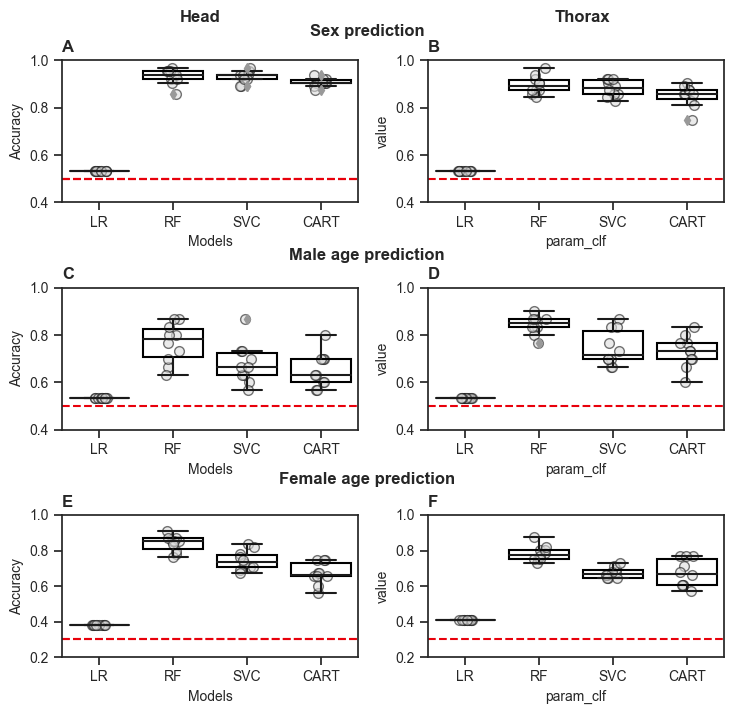

In [31]:
# Figure 4

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":10,
    'xtick.labelsize':10,
    'ytick.labelsize':10}

sn.set_style("ticks")
sn.set_context('notebook', rc=rc)
sn.set_palette('bright', color_codes=True)

fig, ((ax, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(7.5,7), tight_layout=False)

plt.subplots_adjust(hspace=0)


# Sex prediction
sn.boxplot(data=sex_data_plot_head, x='param_clf',y='value',ax=ax, color='white',boxprops={'fill': None})
sn.stripplot(data=sex_data_plot_head, x='param_clf',y='value',ax=ax,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax.lines, color='k')

for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)


sn.boxplot(data=sex_data_plot_thorax, x='param_clf',y='value',ax=ax2, color='white',boxprops={'fill': None})
sn.stripplot(data=sex_data_plot_thorax, x='param_clf',y='value',ax=ax2,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax2.lines, color='k')

for l, box in enumerate(ax2.patches):
    box.set_edgecolor('black')

ax2.axhline(0.5, color='r', ls='--')
ax2.set_ylim(0.4,1)





# Male age prediction
sn.boxplot(data=males_data_plot_thorax, x='param_clf',y='value',ax=ax4, color='white',boxprops={'fill': None})
sn.stripplot(data=males_data_plot_thorax, x='param_clf',y='value',ax=ax4,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax4.lines, color='k')
for l, box in enumerate(ax4.patches):
    box.set_edgecolor('black')

ax4.axhline(0.5, color='r', ls='--')
ax4.set_ylim(0.4,1)


sn.boxplot(data=males_data_plot_head, x='param_clf',y='value',ax=ax3, color='white',boxprops={'fill': None})
sn.stripplot(data=males_data_plot_head, x='param_clf',y='value',ax=ax3,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax3.lines, color='k')
for l, box in enumerate(ax3.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)




# female age prediction
sn.boxplot(data=females_data_plot_head, x='param_clf',y='value',ax=ax5, color='white',boxprops={'fill': None})
sn.stripplot(data=females_data_plot_head, x='param_clf',y='value',ax=ax5,size=7, alpha=0.6, legend=False,linewidth=1,edgecolor='k',color='gainsboro',zorder=0)
plt.setp(ax5.lines, color='k')
for l, box in enumerate(ax5.patches):
    box.set_edgecolor('black')

ax5.axhline(0.3, color='r', ls='--')
ax5.set_ylim(0.2,1)

sn.boxplot(data=females_data_plot_thorax, x='param_clf',y='value',ax=ax6, color='white',boxprops={'fill': None})
sn.stripplot(data=females_data_plot_thorax, x='param_clf',y='value',ax=ax6,size=7,linewidth=1,edgecolor='k',color='gainsboro',zorder=0, alpha=0.6, legend=False)
plt.setp(ax6.lines, color='k')
for l, box in enumerate(ax6.patches):
    box.set_edgecolor('black')

ax6.axhline(0.3, color='r', ls='--')
ax6.set_ylim(0.2,1)






# Overall aesthetics and annotations

plots1 = [ax2,ax4,ax6]

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")



plots2 = [ax,ax3]
for i in plots2:
    i.axhline(0.5, color='r', ls='--')
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")

ax5.axhline(0.3, color='r', ls='--')
ax5.set_ylim(0.2,1)
ax5.set_xlabel("Models")
ax5.set_ylabel("Accuracy")

fig.text(x=0.25,y=1,s="Head",fontweight='bold')
fig.text(x=0.75,y=1,s="Thorax",fontweight='bold')
fig.text(x=0.5,y=0.98,s="Sex prediction",ha='center',fontweight='bold')
fig.text(x=0.5,y=0.66,s="Male age prediction",ha='center',fontweight='bold')
fig.text(x=0.5,y=0.34,s="Female age prediction",ha='center',fontweight='bold')



#plt.savefig("../results/plots/FigS2.tiff", dpi=300, bbox_inches='tight')

In [32]:
variable_importance_sex_head = variable_importance_df(wavenumbers, loaded_model_sex_head)
variable_importance_males_head = variable_importance_df(wavenumbers,loaded_model_males_head)
variable_importance_females_head = variable_importance_df(wavenumbers, loaded_model_females_head)

In [33]:
variable_importance_sex_thorax = variable_importance_df(wavenumbers, loaded_model_sex_thorax)
variable_importance_males_thorax = variable_importance_df(wavenumbers,loaded_model_males_thorax)
variable_importance_females_thorax = variable_importance_df(wavenumbers, loaded_model_females_thorax)

In [46]:
wavenumbers_tsetse_important = {'sex_id_head':variable_importance_sex_head['Wavenumbers'].to_numpy(),
          'sex_id_thorax': variable_importance_sex_thorax['Wavenumbers'].to_numpy(), 
          'age_males_head': variable_importance_males_head['Wavenumbers'].to_numpy(), 
          'age_males_thorax': variable_importance_males_thorax['Wavenumbers'].to_numpy(),
          'age_females_head': variable_importance_females_head["Wavenumbers"].to_numpy(),
          'age_females_thorax': variable_importance_females_thorax['Wavenumbers'].to_numpy()}




In [58]:
df_wavenumbers_tsetse_important = pd.DataFrame(wavenumbers_tsetse_important)
df_wavenumbers_tsetse_important_sort = pd.DataFrame(np.sort(df_wavenumbers_tsetse_important.values, axis=0), index = df_wavenumbers_tsetse_important.index, columns=df_wavenumbers_tsetse_important.columns)

df_wavenumbers_tsetse_important_sort.to_csv("/Users/mauropazmino/Documents/University/TseTse_Project/Pilot/tsetse_MIRS/results/tables/informative_region_results/wvn_import_sort.csv")



Text(0.8, 1, 'Thorax')

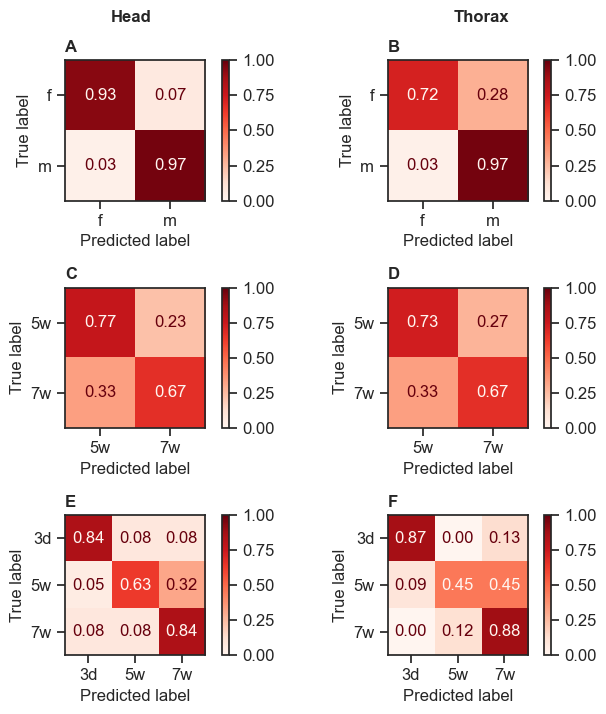

In [140]:
rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}
plt.rcdefaults()
sn.set_palette('bright', color_codes=True)
#rcParams.update({'font.size': 40,"font.family":"arial"})
sn.set_style("ticks")
sn.set_context('notebook',rc=rc )

fig, ((ax, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2, figsize=(7,7), tight_layout=False)


# Sex
disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_sex_head_pred,display_labels=loaded_model_sex_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_sex_thorax_pred,display_labels=loaded_model_sex_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax2, im_kw={'vmin':0, 'vmax':1})


# Age males

disp = ConfusionMatrixDisplay.from_predictions(ym_hd_test,y_male_head_pred,display_labels=loaded_model_males_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax3, im_kw={'vmin':0, 'vmax':1})

disp = ConfusionMatrixDisplay.from_predictions(ym_th_test,y_male_thorax_pred,display_labels=loaded_model_males_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax4, im_kw={'vmin':0, 'vmax':1})


# Age females

disp = ConfusionMatrixDisplay.from_predictions(yf_hd_test,y_female_head_pred,display_labels=loaded_model_females_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax5, im_kw={'vmin':0, 'vmax':1})

disp = ConfusionMatrixDisplay.from_predictions(yf_th_test,y_female_thorax_pred,display_labels=loaded_model_females_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax6, im_kw={'vmin':0, 'vmax':1})

plots_g = [ax,ax2,ax3,ax4,ax5,ax6]
abcd = ["A", "B", "C", "D", "E", "F"]

for i,a in zip(plots_g,abcd):
    i.set_title(a, fontweight='bold',loc="left")

fig.text(0.3,1,s="Head",fontweight='bold', ha='center')
fig.text(0.8,1,s="Thorax", fontweight='bold', ha='center')

#plt.savefig("../results/plots/Fig6.tiff", dpi=300,bbox_inches='tight')


In [190]:
restricted_accuracy_training = {
    'sex_pred_mean': [sex_data_plot_head[sex_data_plot_head['param_clf'] == 'RF']['value'].mean(),
                      sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'RF']['value'].mean()],
    'sex_pred_std': [sex_data_plot_head[sex_data_plot_head['param_clf'] == 'RF']['value'].std(), sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'RF']['value'].std()],
    
    'male_pred_mean':[males_data_plot_head[males_data_plot_head['param_clf'] == 'RF']['value'].mean(),males_data_plot_thorax[males_data_plot_thorax['param_clf'] == 'RF']['value'].mean()],
                       'male_pred_std':[males_data_plot_head[males_data_plot_head['param_clf'] == 'RF']['value'].std(),males_data_plot_thorax[males_data_plot_thorax['param_clf'] == 'RF']['value'].std()],
                       'fem_pred_mean':[females_data_plot_head[females_data_plot_head['param_clf']=='RF']['value'].mean(),females_data_plot_thorax[females_data_plot_thorax['param_clf']=='RF']['value'].mean()],'fem_pred_std':[females_data_plot_head[females_data_plot_head['param_clf']=='RF']['value'].std(),females_data_plot_thorax[females_data_plot_thorax['param_clf']=='RF']['value'].std()]}

In [200]:
restricted_accuracy_test = {
    'sex':[accuracy_score(y_hd_test,y_sex_head_pred),
                accuracy_score(y_th_test,y_sex_thorax_pred)],
    'males': [accuracy_score(ym_hd_test,y_male_head_pred),
                   accuracy_score(ym_th_test,y_male_thorax_pred)],
    'females': [accuracy_score(yf_hd_test,y_female_head_pred),
                accuracy_score(yf_th_test,y_female_thorax_pred)]
}

In [203]:
restricted_acc_test_df = pd.DataFrame.from_dict(restricted_accuracy_test).T

In [204]:
restricted_acc_test_df.rename(columns={0:'Head', 1:'Thorax'}, inplace=True)

,Head,Thorax
sex,0.950000,0.825000
males,0.729730,0.702703
females,0.782609,0.742857


In [226]:
arrays = [['Sex','Sex','Males','Males','Females','Females'],["head", 'thorax',"head", 'thorax',"head", 'thorax']]

df2 = pd.DataFrame([
    [
        sex_data_plot_head[sex_data_plot_head['param_clf'] == 'RF']['value'].mean(),
        sex_data_plot_head[sex_data_plot_head['param_clf'] == 'RF']['value'].std(),
        accuracy_score(y_hd_test,y_sex_head_pred)],
    [
        sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'RF']['value'].mean(),
        sex_data_plot_thorax[sex_data_plot_thorax['param_clf'] == 'RF']['value'].std(),
        accuracy_score(y_th_test,y_sex_thorax_pred)],
    [
        males_data_plot_head[males_data_plot_head['param_clf'] == 'RF']['value'].mean(), 
        males_data_plot_head[males_data_plot_head['param_clf'] == 'RF']['value'].std(), 
        accuracy_score(ym_hd_test,y_male_head_pred)],
    [
        males_data_plot_thorax[males_data_plot_thorax['param_clf'] == 'RF']['value'].mean(), 
        males_data_plot_thorax[males_data_plot_thorax['param_clf'] == 'RF']['value'].std(), accuracy_score(ym_th_test,y_male_thorax_pred)],
    [
        females_data_plot_head[females_data_plot_head['param_clf']=='RF']['value'].mean(),
        females_data_plot_head[females_data_plot_head['param_clf']=='RF']['value'].std(),
        accuracy_score(yf_hd_test,y_female_head_pred)],
    [
        females_data_plot_thorax[females_data_plot_thorax['param_clf']=='RF']['value'].mean(),
        females_data_plot_thorax[females_data_plot_thorax['param_clf']=='RF']['value'].std(),
        accuracy_score(yf_th_test,y_female_thorax_pred)]],
                    columns=['Accuracy (train set)', 'std', 'Accuracy (test set)'], index=arrays)

df2.to_csv("../results/tables/informative_region_results/table3.csv")
df2

Accuracy (train set)       std  Accuracy (test set)
Sex     head                0.931250  0.031423             0.950000
        thorax              0.896875  0.038415             0.825000
Males   head                0.766667  0.081650             0.729730
        thorax              0.843333  0.038650             0.702703
Females head                0.840000  0.045191             0.782609
        thorax              0.783929  0.043293             0.742857

In [191]:
pd.DataFrame.from_dict(restricted_accuracy_training)

,sex_pred_mean,sex_pred_std,male_pred_mean,male_pred_std,fem_pred_mean,fem_pred_std
0,0.931250,0.031423,0.766667,0.08165,0.840000,0.045191
1,0.896875,0.038415,0.843333,0.03865,0.783929,0.043293
